In [1]:
!ls

drive  sample_data


In [2]:
import os
os.chdir('drive/MyDrive/Underwater-image-enhancement-using-color-balance-and-fusion')

0.22251549825837275, 0.573684687026106, 0.6123484222332009


Text(0.5, 1.0, 'White balanced Image')

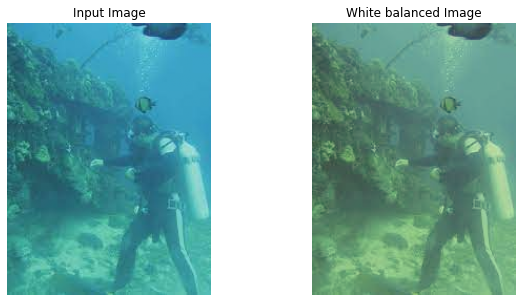

In [ ]:
####
# Underwater image enhancement using color balance and fusion
# by Codruta O. Ancuti , Cosmin Ancuti, Christophe De Vleeschouwer , and Philippe Bekaert 


import cv2
import numpy as np
import matplotlib.pyplot as plt

## Underwater white balancing

# Load image and split channels
rgbImage = (cv2.imread('input_images/underwater_img1.jpeg'))[:,:,::-1]/255.0 # cv.imread reads AS BGR format (change to RGB)


Ir = np.array(rgbImage[:,:,0])
Ig = np.array(rgbImage[:,:,1])
Ib = np.array(rgbImage[:,:,2])

# Mean intensity for the 3(R/G/B) channels
Ir_mean = np.mean(Ir)
Ig_mean = np.mean(Ig)
Ib_mean = np.mean(Ib)

print("{}, {}, {}".format(Ir_mean, Ig_mean, Ib_mean))

# FOR balancing - constants (alpha) are adjusted if needed according to the image.

# # color compensation (WHEN GREENISH heavy)
# alpha = 1.0
# Ir_compensate = alpha*(Ig_mean - Ir_mean)*((1.0 - Ir)*Ig)
# Ir_final = Ir + Ir_compensate

# alpha = 1.0
# Ib_compensate = alpha*(Ig_mean - Ib_mean)*((1.0 - Ib)*Ig)
# Ib_final = Ib + Ib_compensate

# color compensation (WHEN GREENISH-BLUISH)
alpha = 1.0
Ir_compensate = alpha*(Ig_mean - Ir_mean)*((1.0 - Ir)*Ig)
Ir_final = Ir + Ir_compensate

alpha = 0.5
Ig_compensate_neg = alpha*(Ir_mean - Ig_mean)*Ig # negatively compensate
Ig_final = Ig + Ig_compensate_neg

alpha = 0.6
Ib_compensate_neg = alpha*(Ir_mean - Ib_mean)*Ib # negatively compensate
Ib_final = Ib + Ib_compensate_neg

Iwb = np.dstack((Ir_final,Ig_final,Ib_final))

Iwb = np.dstack((Ir_final,Ig,Ib_final))

f, axarr = plt.subplots(1,2, figsize = (10,5))

axarr[0].imshow(rgbImage)
axarr[0].axis('off')
axarr[0].set_title("Input Image")

axarr[1].imshow(Iwb)
axarr[1].axis('off')
axarr[1].set_title("White balanced Image")

0.13669596349422852


Text(0.5, 1.0, 'Gamma corrected image')

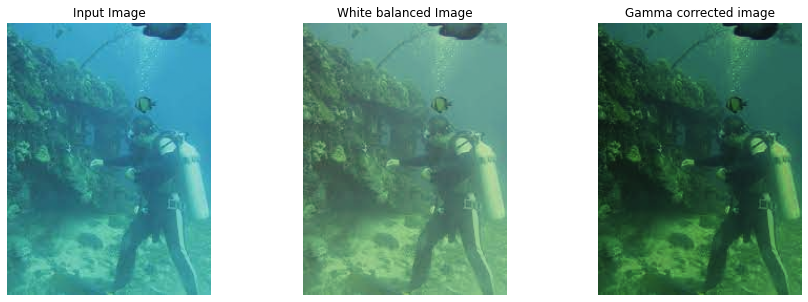

In [ ]:
## Gamma correction applied on white balanced image (INPUT-1 for multiscale fusion)
gamma = 2.0
Igamma = Iwb ** gamma

print(Iwb.min())

f, axarr = plt.subplots(1,3, figsize = (15, 5))

axarr[0].imshow(rgbImage)
axarr[0].axis('off')
axarr[0].set_title("Input Image")

axarr[1].imshow(Iwb)
axarr[1].axis('off')
axarr[1].set_title("White balanced Image")

axarr[2].imshow(Igamma)
axarr[2].axis('off')
axarr[2].set_title("Gamma corrected image")

Text(0.5, 1.0, 'Final sharpened image')

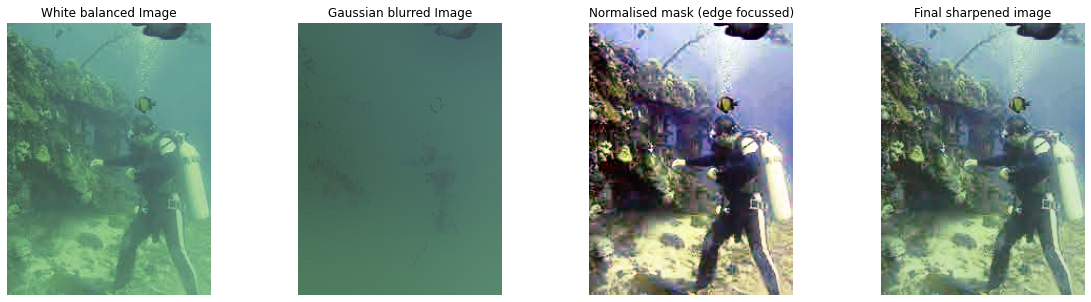

In [ ]:
## Unsharp masking (Input 2 for multiscale fusion)
sigma = 20.0 #higher sigma, need high blur (strengthen high feq mildly, else noise too magnify)
Ig = Iwb
from skimage import filters
# apply Gaussian blur, creating a new image
for i in range(20): # more iterations, better mask (blurry) 
  Ig = filters.gaussian(Ig, sigma=(sigma, sigma), truncate=6.0, multichannel=True) # kernel 6 times sigma, truncate formula - nearly the ratio
  Ig = np.minimum(Ig, Iwb)

# use normalised unsharp masking
strength = 0.8 # strength less than favourable (here when tested)

# unsharp mask deducted
Inorm = Iwb - strength*Ig
# print(Inorm.min())

# histogram eq for R/G/B
Inorm = Inorm * 255
Inorm = Inorm.astype(np.uint8)
R, G, B = cv2.split(Inorm)

output1_R = cv2.equalizeHist(R)
output1_G = cv2.equalizeHist(G)
output1_B = cv2.equalizeHist(B)

Inorm = cv2.merge((output1_R, output1_G, output1_B))
Inorm = Inorm/255.0
# add normalised mask (edge focussed) to input image, averaged to give output
Isharp = (Iwb + Inorm)/2

# plot images (white balanced, unsharp mask, normalised mask - edge focussed, final sharpened image)
f, axarr = plt.subplots(1,4, figsize = (20, 5))

axarr[0].imshow(Iwb)
axarr[0].axis('off')
axarr[0].set_title("White balanced Image")

axarr[1].imshow(Ig)
axarr[1].axis('off')
axarr[1].set_title("Gaussian blurred Image")

axarr[2].imshow(Inorm)
axarr[2].axis('off')
axarr[2].set_title("Normalised mask (edge focussed)")

axarr[3].imshow(Isharp)
axarr[3].axis('off')
axarr[3].set_title("Final sharpened image")


Text(0.5, 1.0, 'Saturation weight map')

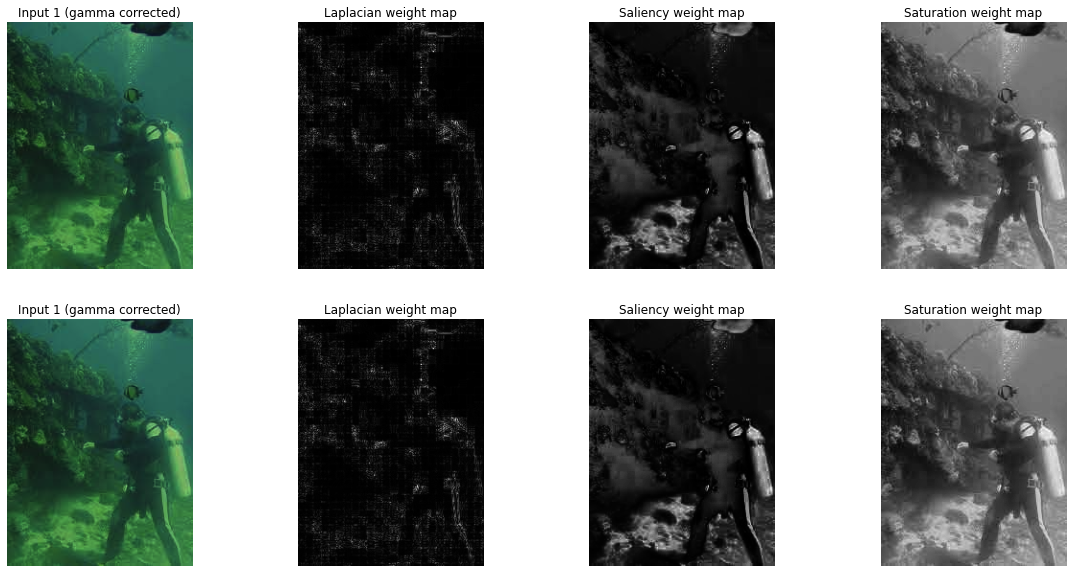

In [ ]:
from weight_maps import saliency_weight, laplacian_weight, saturation_weight

## Weights, for performing fusion
Igamma_lab = cv2.cvtColor(Igamma.astype('float32'), cv2.COLOR_RGB2LAB)
Isharp_lab = cv2.cvtColor(Isharp.astype('float32'), cv2.COLOR_RGB2LAB)

# input 1 - gamma corrected
Igamma
Rgamma = Igamma_lab[:, :, 0]
# input 2 - unsharp masked
Isharp
Rsharp = Isharp_lab[:, :, 0]

# calculate laplacian contrast weight
WCgamma = laplacian_weight(Igamma)
WCsharp = laplacian_weight(Isharp)

# calculate the saliency weight
WSgamma = saliency_weight(Igamma_lab)
WSsharp = saliency_weight(Isharp_lab)

# calculate the saturation weight
WSATgamma = saturation_weight(Igamma, Rgamma)
WSATsharp = saturation_weight(Isharp, Rsharp)

# Plot inputs (after correction) and corresponding weight maps
f, axarr = plt.subplots(2,4, figsize = (20, 10))


# Input 1 - Gamma corrected image
axarr[0, 0].imshow(Igamma)
axarr[0, 0].axis('off')
axarr[0, 0].set_title("Input 1 (gamma corrected)")

axarr[0, 1].imshow(WCgamma, cmap = 'gray')
axarr[0, 1].axis('off')
axarr[0, 1].set_title("Laplacian weight map")

axarr[0, 2].imshow(WSgamma, cmap='gray')
axarr[0, 2].axis('off')
axarr[0, 2].set_title("Saliency weight map")

axarr[0, 3].imshow(WSATgamma, cmap='gray')
axarr[0, 3].axis('off')
axarr[0, 3].set_title("Saturation weight map")


# Input 2 - Sharpened image (using Unsharp mask)
axarr[1, 0].imshow(Igamma)
axarr[1, 0].axis('off')
axarr[1, 0].set_title("Input 1 (gamma corrected)")

axarr[1, 1].imshow(WCgamma, cmap = 'gray')
axarr[1, 1].axis('off')
axarr[1, 1].set_title("Laplacian weight map")

axarr[1, 2].imshow(WSgamma, cmap='gray')
axarr[1, 2].axis('off')
axarr[1, 2].set_title("Saliency weight map")

axarr[1, 3].imshow(WSATgamma, cmap='gray')
axarr[1, 3].axis('off')
axarr[1, 3].set_title("Saturation weight map")


Text(0.5, 1.0, 'Enhanced image (Native fusion)')

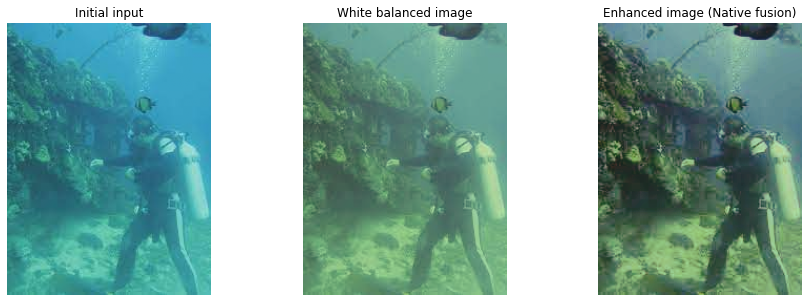

In [ ]:
## Normalise weights - Use for fusion

# weight 1 corresponds to input 1 (gamma corrected)
Wgamma = (WCgamma + WSgamma + WSATgamma + 0.1)/ (WCgamma + WSgamma + WSATgamma + WCsharp + WSsharp + WSATsharp + 0.2)
# weight 2 corresponds to input 2 (unsharp masked)
Wsharp = (WCsharp + WSsharp + WSATsharp + 0.1)/ (WCgamma + WSgamma + WSATgamma + WCsharp + WSsharp + WSATsharp + 0.2)

#Native Fusion
W1_f = np.dstack((Wgamma, Wgamma, Wgamma))
W2_f = np.dstack((Wsharp, Wsharp, Wsharp))
# direct - weighted sum
NativeFusionImg = Igamma*W1_f + Isharp*W2_f

f, axarr = plt.subplots(1, 3, figsize=(15,5))

axarr[0].imshow(rgbImage)
axarr[0].axis('off')
axarr[0].set_title("Initial input")

axarr[1].imshow(Iwb)
axarr[1].axis('off')
axarr[1].set_title("White balanced image")

axarr[2].imshow(NativeFusionImg)
axarr[2].axis('off')
axarr[2].set_title("Enhanced image (Native fusion)")

Text(0.5, 1.0, 'Final enhanced image (Multiscale fusion)')

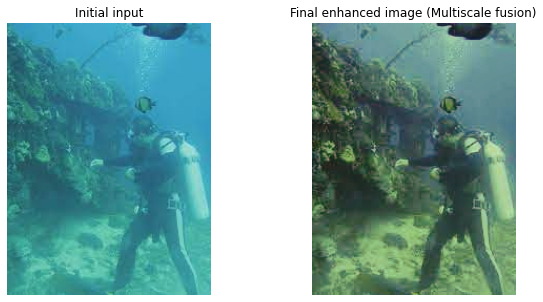

In [ ]:
## Multiscale fusion
from img_pyramids import gaussian_pyramid, laplacian_pyramid, pyramid_reconstruct

# calculate the gaussian pyramid
level = 5
WTgamma = gaussian_pyramid(Wgamma, level)
WTsharp = gaussian_pyramid(Wsharp, level)

# calculate the laplacian pyramid
# input1
Rgamma = laplacian_pyramid(Igamma[:, :, 0], level)
Ggamma = laplacian_pyramid(Igamma[:, :, 1], level)
Bgamma = laplacian_pyramid(Igamma[:, :, 2], level)
# input2
Rsharp = laplacian_pyramid(Isharp[:, :, 0], level)
Gsharp = laplacian_pyramid(Isharp[:, :, 1], level)
Bsharp = laplacian_pyramid(Isharp[:, :, 2], level)

# fusion
Rr = []
Rg = []
Rb = []
for k in range(level):
   Rr.append(WTgamma[k]*Rgamma[k] + WTsharp[k]*Rsharp[k])
   Rg.append(WTgamma[k]*Ggamma[k] + WTsharp[k]*Gsharp[k])
   Rb.append(WTgamma[k]*Bgamma[k] + WTsharp[k]*Bsharp[k])

# reconstruct & output
R = pyramid_reconstruct(Rr)
G = pyramid_reconstruct(Rg)
B = pyramid_reconstruct(Rb)
MultiscaleFusionImg = np.dstack((R, G, B))

f, axarr = plt.subplots(1, 2, figsize=(10,5))

axarr[0].imshow(rgbImage)
axarr[0].axis('off')
axarr[0].set_title("Initial input")

axarr[1].imshow(MultiscaleFusionImg)
axarr[1].axis('off')
axarr[1].set_title("Final enhanced image (Multiscale fusion)")


In [4]:
!git init

Initialized empty Git repository in /content/drive/MyDrive/Underwater-image-enhancement-using-color-balance-and-fusion/.git/


In [8]:
!git commit -m "initial commit"

On branch master

Initial commit

Untracked files:
	Implementation and Concepts.gdoc
	Underwater Image enhancement.ipynb
	img_pyramids.py
	input_images/
	output_screenshots/
	weight_maps.py

nothing added to commit but untracked files present


In [7]:
!git config --global user.email "aniruddhbansal2000@gmail.com"
!git config --global user.name "Aniruddh Bansal"


In [9]:
!git add .

error: open("Implementation and Concepts.gdoc"): Operation not supported
error: unable to index file Implementation and Concepts.gdoc
fatal: adding files failed


In [11]:
!git add 'Underwater Image enhancement.ipynb' 'img_pyramids.py input_images/ output_screenshots/ weight_maps.py

fatal: pathspec 'Underwater' did not match any files
